# Facial Expression Recognition (FER2013)

The aim of this project is to develop a tool to classify facial expressions based on a set of pre-defined classes to help those who have difficulty recognising facial expressions. It will be based on the FER2013 Kaggle challenge dataset.

## Data Preparation


### Data visualisation

In [ ]:
# Import all required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage.transform import resize

from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, F1Score, AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

from sklearn.model_selection import ParameterGrid

from PIL import Image
import ipywidgets as widgets
from IPython.display import display
import io

# Set random seed to ensure processes are consistent across runs
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Suppress warnings not critical to current workflow
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the file path and read the CSV file
filepath = '/content/drive/My Drive/fer2013.csv'
df = pd.read_csv(filepath)

# To show the size of dataset (rows, columns)
print("Shape: ", df.shape)

# Display the first few rows of the DataFrame
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape:  (35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


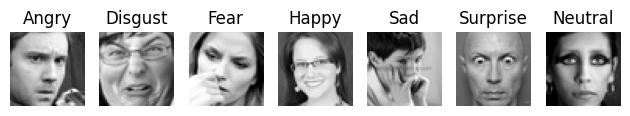

In [ ]:
# Class number to text
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

for label in df['emotion'].unique():
    # Extract pixel data from first matching row
    px = df[df['emotion']==label].pixels.iloc[0]
    # Split the space-separated pixel string into an array
    px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
    # Plot images
    plt.subplot(1, 7, label+1)
    plt.imshow(px, cmap='gray')
    plt.title(emotions[label])
    plt.axis('off')
    plt.tight_layout()

### Baseline

In [ ]:
# To show the number of images in each category
df['emotion'].value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


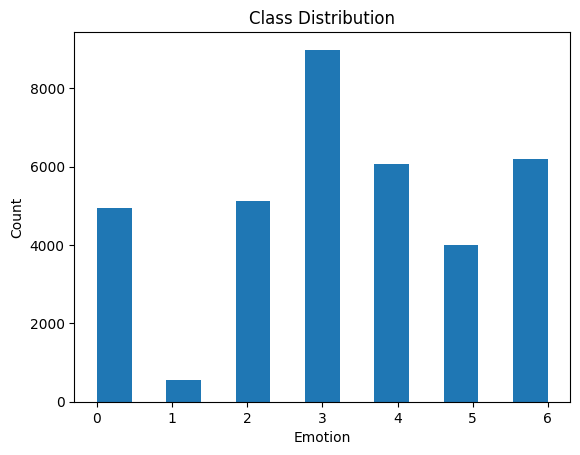

In [ ]:
# Plot histogram to visualise the class distribution
plt.hist(df['emotion'], bins=13)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
# Calculate the common sense baseline (when happy is always picked)
naive_baseline = 8989/35887
"{:.2f}".format(naive_baseline)

'0.25'

Since the "Happy" category has the most number of examples, if the classifier always predicts "Happy", an accuracy of approximately 25% will be achieved. From my literature review, the highest-known accuracy for the FER2013 dataset is 75.2% (Pramerdorfer and Kampel).

### Split data into training and testing

In [ ]:
# To show the number of images in each category
df['Usage'].value_counts()

,count
Usage,
Training,28709
PublicTest,3589
PrivateTest,3589


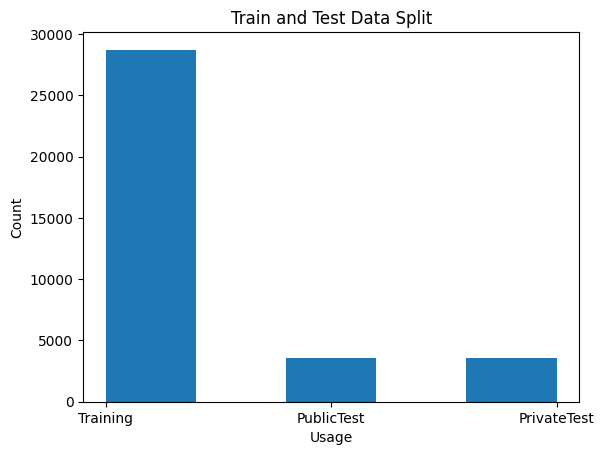

In [ ]:
# Plot histogram to show train and test data split
plt.hist(df['Usage'], bins=5)
plt.xlabel('Usage')
plt.ylabel('Count')
plt.title('Train and Test Data Split')
plt.show()

In [ ]:
# Separate the dataset based on the 'Usage' column
train_data = df[df['Usage'] == 'Training']
val_data = df[df['Usage'] == 'PublicTest']
test_data = df[df['Usage'] == 'PrivateTest']

# Function to extract features and labels
def extract_features_and_labels(df):
    pixels = df['pixels'].tolist()
    labels = df['emotion'].tolist()
    # Convert pixels from strings to numpy arrays
    features = [np.array(pixel.split(), dtype='float32') for pixel in pixels]
    features = np.array(features)
    # Reshape the features to 48x48 to maintain uniformity
    # (FER2013 consist of 48x48 grayscale images)
    features = features.reshape((features.shape[0], 48, 48, 1))
    # Convert grayscale images to RGB images
    features = tf.convert_to_tensor(features)
    features = tf.image.grayscale_to_rgb(features)
    # Normalise from [0, 255] to [0, 1]
    features = features/255
    # Convert labels to one-hot encoding
    labels = to_categorical(labels, num_classes=7)
    return features, labels

# Extract features and labels for each split
X_train, y_train = extract_features_and_labels(train_data)
X_val, y_val = extract_features_and_labels(val_data)
X_test, y_test = extract_features_and_labels(test_data)

In [ ]:
# Check that data transformation is consistent with what is expected
def test_extract_features_and_labels():
    features, labels = extract_features_and_labels(train_data)
    # Check shapes of the outputs
    assert features.shape == (28709, 48, 48, 3)
    assert labels.shape == (28709, 7)

test_extract_features_and_labels()

## Build the model

In [ ]:
# Define the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define the metrics
METRICS = ['accuracy',
           Precision(),
           Recall(),
           F1Score(name="f1_score", average='micro'),
           AUC(name="auc")]

### Model 1

In [ ]:
# Freeze the layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Define the model architecture
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=x)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,980,935 (57.15 MB)

 Trainable params: 266,247 (1.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=METRICS)

# Callback function that monitors validation loss
early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5, verbose=0)

# Train and validate the model
model_history = model.fit(X_train, y_train,
                          batch_size=64, epochs=50,
                          validation_data=(X_val, y_val),
                          callbacks=[early_stop],
                          verbose=0)

In [ ]:
# Check that predictions are consistent with what is expected
def test_model_prediction():
    predictions = model.predict(X_val)
    # Convert predicted probabilities to class indices
    predicted_classes = np.argmax(predictions, axis=1)
    # Check that all predicted classes are within the expected range
    assert set(predicted_classes) <= {0,1,2,3,4,5,6}, "Predictions should be a number from 0 to 6"

test_model_prediction()

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
# To store scores for summary table
eval = []

# Function to evaluate trained model and print metric scores
def print_scores(m):
    # Evaluate trained model
    scores = m.evaluate(X_val, y_val, verbose=0)
    eval.append(scores)

    # Print scores
    print('Loss: {:.2f}'.format(scores[0]))
    print('Accuracy: {:.2f}'.format(scores[1]))
    print('Precision: {:.2f}'.format(scores[2]))
    print('Recall: {:.2f}'.format(scores[3]))
    print('F1 Score: {:.2f}'.format(scores[4]))
    print('AUC: {:.2f}'.format(scores[5]))

In [ ]:
# Evaluate trained model and print metric scores
print_scores(model)

Loss: 1.58
Accuracy: 0.39
Precision: 0.67
Recall: 0.12
F1 Score: 0.39
AUC: 0.77


In [ ]:
# Function to plot graph
def plot_history(history) :
    # Clear the figure
    plt.clf()
    # Retrieves the training and validation loss
    loss, val_loss = history.history['loss'], history.history['val_loss']
    # Generate list of epochs for plotting
    epochs = range(1, len(loss)+1)
    # Plot training metric (blue)
    plt.plot(epochs, loss, 'b.', label='Training loss')
    # Plot validation metric (red)
    plt.plot(epochs, val_loss, 'r.', label='Validation loss')
    # Set x-axis limits
    plt.xlim([0, len(loss)])
    # Set title of plot
    plt.title('Training and Validation loss')
    # Set x-axis and y-axis labels
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # To display legend
    plt.legend()
    # Add grid
    plt.grid()
    # To display plot
    _ = plt.show()

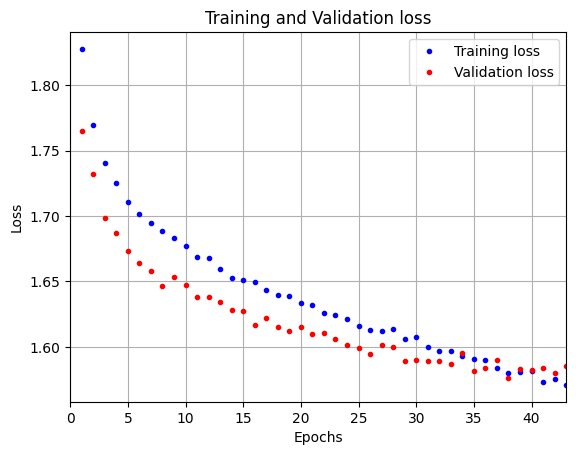

In [ ]:
# Plot training and validation loss
plot_history(model_history)

### Model 2

In [ ]:
# Define the model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

# Create final model
model_2 = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_2.compile(optimizer=Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=METRICS)

# Train and validate the model
model_2_history = model_2.fit(X_train, y_train,
                              batch_size=64, epochs=50,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stop],
                              verbose=0)

model_2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,247,175 (58.16 MB)

 Trainable params: 532,487 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Evaluate trained model and print metric scores
print_scores(model_2)

Loss: 1.98
Accuracy: 0.18
Precision: 0.70
Recall: 0.07
F1 Score: 0.29
AUC: 0.68


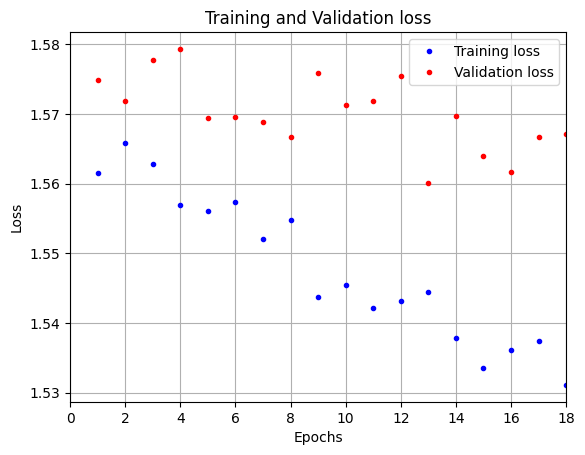

In [ ]:
# Plot training and validation loss
plot_history(model_2_history)

### Model 3

In [ ]:
# Define the model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

# Create final model
model_3 = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_3.compile(optimizer=Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=METRICS)

# Train and validate the model
model_3_history = model_3.fit(X_train, y_train,
                              batch_size=64, epochs=50,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stop],
                              verbose=0)

model_3.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,110,471 (57.64 MB)

 Trainable params: 395,783 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Evaluate trained model and print metric scores
print_scores(model_3)

Loss: 2.12
Accuracy: 0.02
Precision: 0.67
Recall: 0.07
F1 Score: 0.20
AUC: 0.64


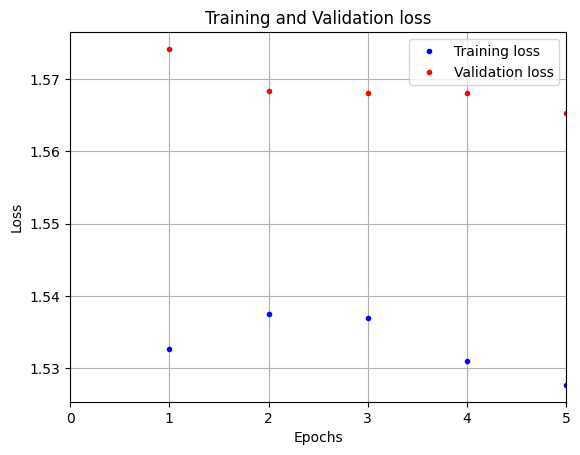

In [ ]:
# Plot training and validation loss
plot_history(model_3_history)

### Model 4

In [ ]:
# Define the model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

# Create final model
model_4 = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_4.compile(optimizer=Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=METRICS)

# Train and validate the model
model_4_history = model_4.fit(X_train, y_train,
                              batch_size=64, epochs=50,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stop],
                              verbose=0)

model_4.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,142,471 (57.76 MB)

 Trainable params: 427,783 (1.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Evaluate trained model and print metric scores
print_scores(model_4)

Loss: 1.98
Accuracy: 0.13
Precision: 0.70
Recall: 0.07
F1 Score: 0.26
AUC: 0.66


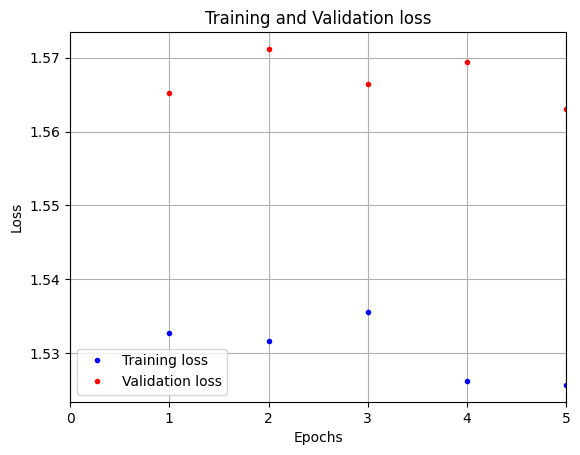

In [ ]:
# Plot training and validation loss
plot_history(model_4_history)

### Model 5

In [ ]:
# Define the model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

# Create final model
model_5 = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_5.compile(optimizer=Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=METRICS)

# Train and validate the model
model_5_history = model_5.fit(X_train, y_train,
                              batch_size=64, epochs=50,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stop],
                              verbose=0)

model_5.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,150,279 (57.79 MB)

 Trainable params: 435,591 (1.66 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Evaluate trained model and print metric scores
print_scores(model_5)

Loss: 1.94
Accuracy: 0.15
Precision: 0.68
Recall: 0.07
F1 Score: 0.27
AUC: 0.67


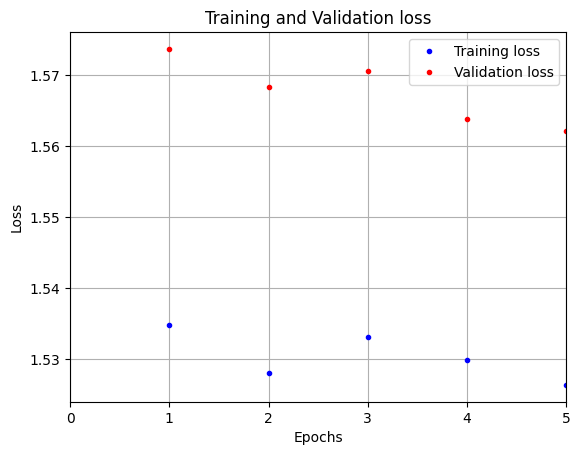

In [ ]:
# Plot training and validation loss
plot_history(model_5_history)

### Results

In [ ]:
# Show table of results
results = pd.DataFrame(eval)
results.columns = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
results.index = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']
results.round(2)

,Loss,Accuracy,Precision,Recall,F1 Score,AUC
Model 1,1.58,0.39,0.67,0.12,0.39,0.77
Model 2,1.98,0.18,0.70,0.07,0.29,0.68
Model 3,2.12,0.02,0.67,0.07,0.20,0.64
Model 4,1.98,0.13,0.70,0.07,0.26,0.66
Model 5,1.94,0.15,0.68,0.07,0.27,0.67


Based on the results, model 1 is the best-performing overall. Hence, hyperparameter tuning will be conducted on it.

### Hyperparameter tuning

In [ ]:
# Function compile, train and evaluate the model
def custom_grid_search(batch_size, epochs, learning_rate):
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=METRICS)

    # Train and validate the model
    model_history = model.fit(X_train, y_train,
                              batch_size=batch_size, epochs=epochs,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stop],
                              verbose=0)

    # Evaluate the model
    scores = model.evaluate(X_val, y_val, verbose=0)
    return scores

In [ ]:
# To store scores for summary table
param_eval = []

# Define your parameter grid
param_grid = {
    'batch_size': [32, 64],
    'epochs': [25, 50],
    'learning_rate': [1e-7, 1e-4]
}

# Iterate through parameter combinations
for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    scores = custom_grid_search(
        batch_size = params['batch_size'],
        epochs = params['epochs'],
        learning_rate = params['learning_rate']
    )
    param_eval.append(scores)

Testing parameters: {'batch_size': 32, 'epochs': 25, 'learning_rate': 1e-07}
Testing parameters: {'batch_size': 32, 'epochs': 25, 'learning_rate': 0.0001}
Testing parameters: {'batch_size': 32, 'epochs': 50, 'learning_rate': 1e-07}
Testing parameters: {'batch_size': 32, 'epochs': 50, 'learning_rate': 0.0001}
Testing parameters: {'batch_size': 64, 'epochs': 25, 'learning_rate': 1e-07}
Testing parameters: {'batch_size': 64, 'epochs': 25, 'learning_rate': 0.0001}
Testing parameters: {'batch_size': 64, 'epochs': 50, 'learning_rate': 1e-07}
Testing parameters: {'batch_size': 64, 'epochs': 50, 'learning_rate': 0.0001}


In [ ]:
# Show table of results
param_results = pd.DataFrame(param_eval)
param_results.columns = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
param_results.round(2)

,Loss,Accuracy,Precision,Recall,F1 Score,AUC
0,1.75,0.35,0.70,0.07,0.30,0.75
1,1.76,0.34,0.73,0.10,0.35,0.78
2,1.94,0.28,0.65,0.07,0.25,0.70
3,1.56,0.42,0.75,0.15,0.40,0.80
4,1.98,0.28,0.65,0.07,0.24,0.68
5,1.68,0.36,0.72,0.08,0.32,0.76
6,1.88,0.30,0.68,0.08,0.28,0.72
7,1.55,0.40,0.75,0.11,0.40,0.78


Based on the results, the model trained with a batch size of 32, 50 epochs, and a learning rate of 1e-4 is the best performing model.

## Testing

Now that the parameters of the best-performing model have been found, it will be retrained on the entire training dataset instead of just a partial subset.

In [ ]:
# Combine training set and validation set
X_train_all = np.concatenate([X_train, X_val])
y_train_all = np.concatenate([y_train, y_val])

# Compile final model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=METRICS)

# Train final model
model_history = model.fit(X_train_all, y_train_all,
                          batch_size=32, epochs=50,
                          callbacks=[early_stop],
                          verbose=0)

In [ ]:
# Evaluate final model on totally unseen data
final_scores = model.evaluate(X_test, y_test, verbose=0)

# Print scores
print('Naive Baseline = {:.2f}, Highest known accuracy = {:.2f}'.format(naive_baseline, 0.752))
print('Accuracy: {:.2f}'.format(final_scores[1]))
print('Precision: {:.2f}'.format(final_scores[2]))
print('Recall: {:.2f}'.format(final_scores[3]))
print('F1 Score: {:.2f}'.format(final_scores[4]))
print('AUC: {:.2f}'.format(final_scores[5]))

Naive Baseline = 0.25, Highest known accuracy = 0.75
Accuracy: 0.42
Precision: 0.74
Recall: 0.15
F1 Score: 0.40
AUC: 0.80


From the evaluation metrics above, it can be concluded that the model can perform better than the naive baseline. High precision indicates that the model is reliable in predicting positives. However, considering other metrics and the fact that the highest known accuracy is 0.75, the model still has potential for further improvement. Nonetheless, this model can still be used for predictions for the tool that is intended to be developed.

## Classification Tool

In [ ]:
model.save('./content/drive/My Drive/model.h5')

In [ ]:
reloaded_model = tf.keras.models.load_model('./content/drive/My Drive/model.h5')

In [ ]:
# Check that both models are identical and make the same prediciton
prediction_1 = model.predict(X_val)
prediction_2 = reloaded_model.predict(X_val)
difference = np.abs(prediction_1 - prediction_2)
print(difference.max())

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
0.0


In [ ]:
def predict(image, reloaded_model):
    # Open image and ensure it is in RGB format
    img = Image.open(image).convert('RGB')
    # Resize image
    img = img.resize((48, 48))
    # Convert image to numpy array and normalize pixel values
    img_array = np.array(img).astype('float32') / 255
    # Ensure shape is (1, 48, 48, 3)
    img_array = np.expand_dims(img_array, axis=0)
    # Make prediction
    result = reloaded_model.predict(img_array)
    # Get the class with the highest probability
    predicted_class = np.argmax(result, axis=1)[0]
    # Show image
    plt.imshow(img)
    return predicted_class

Users can upload the image they want to classify, and the tool will return the predicted class.

0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Sad, 5: Surprise, 6: Neutral


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


5

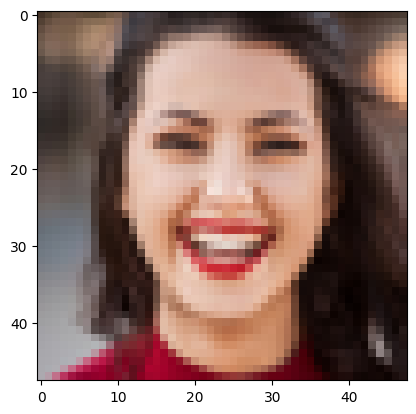

In [ ]:
# Predict class
image_path = '/content/drive/My Drive/happy4.jpg'
predict(image_path, reloaded_model)

This image was classified as "Surprise".

In [ ]:
# File upload widget
upload_button = widgets.FileUpload(accept='image/*', multiple=False)

def predict(change):
    # Extract file content
    uploaded_file = next(iter(upload_button.value.values()))
    content = uploaded_file['content']
    # Open image and ensure it is in RGB format
    img = Image.open(io.BytesIO(content)).convert('RGB')
    # Resize image
    img = img.resize((48, 48))
    # Convert image to numpy array and normalize pixel values
    img_array = np.array(img).astype('float32') / 255
    # Ensure shape is (1, 48, 48, 3)
    img_array = np.expand_dims(img_array, axis=0)
    # Make prediction
    result = reloaded_model.predict(img_array)
    # Get the class with the highest probability
    predicted_class = np.argmax(result, axis=1)[0]
    # Print class text
    print(emotions.get(predicted_class))
    # Show image
    plt.imshow(img)

# Event listener
upload_button.observe(predict, names='value')

# Display upload button
display(upload_button)

FileUpload(value={}, accept='image/*', description='Upload')